In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from utils_cells import get_images_list, transform_image, transform_target, resize_with_padding
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import torchvision.transforms.functional as F
import torch
from torchvision import transforms
from torchvision.transforms import functional as F
import cv2
from sklearn.model_selection import train_test_split
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torchmetrics import Precision, Recall
import numpy as np
import datetime
import random
import time
import torchvision.models as models

import random

class ImageDataset(Dataset):
    def __init__(self, data_path, transform=None, target_transform=None, reduce=False):
        self.transform = transform
        self.target_transform = target_transform
        self.dataset = shuffle(self.load_dataset(data_path))

    def load_dataset(self, path):
        path = []
        classes = []
        for image_class in os.listdir('cells_final'):
            for img in os.listdir(f'cells_final/{image_class}'):
                path.append(f'cells_final/{image_class}/{img}')
                classes.append(image_class)

        dataset_final = pd.DataFrame()
        dataset_final['path'] = path
        dataset_final['class'] = classes
        return dataset_final                
                          
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = cv2.imread(f'{self.dataset["path"].loc[idx]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_CUBIC)
        
        #image = resize_with_padding(image, (32, 32))
        image = image.astype(np.float32)
        image = image/255.0
        image = self.transform(image = image)['image'] if self.transform is not None else image

        target = self.dataset['class'].loc[idx]

        if target.strip() == 'normal':
            target_ = [1, 0, 0, 0]
        elif target.strip() == 'inflammatory':
            target_ = [0, 1, 0, 0]
        elif target.strip() == 'tumor':
            target_ = [0, 0, 1, 0]
        elif target.strip() == 'other':
            target_ = [0, 0, 0, 1]
        else:
            print(target)
        
        image = F.to_tensor(image)
        

        return image.float(), torch.Tensor(np.array(target_, dtype=np.float32))

/home/adam/miniconda3/envs/cells/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
from einops import rearrange

import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # [3, 32, 32] -> [16, 16, 16]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # [16, 16, 16] -> [32, 8, 8]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [32, 8, 8] -> [64, 4, 4]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128) ,
            nn.ReLU(),
        )



        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(128, 64 * 4 * 4) , # Expand back to match the flattened input size
            nn.Unflatten(dim=1, unflattened_size=(64, 4, 4)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64, 4, 4] -> [32, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # [32, 8, 8] -> [16, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),   # [16, 16, 16] -> [3, 32, 32]
            nn.Sigmoid(),  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example usage


model = ConvAutoencoder()

# Sample input
x = torch.randn(1, 3, 32, 32)
reconstructed_img = model(x)

print(reconstructed_img.shape)  # Should output torch.Size([1, 3, 32, 32])


torch.Size([1, 3, 32, 32])


In [3]:
model = model.to('cuda')

In [4]:
import time
import torch
import wandb
from torch.utils.data import DataLoader
import numpy as np

# Initialize WandB
run_name = f'conv_autoencoder_training_{datetime.datetime.now()}'

# Configuration
batch_size = 1024
learning_rate = 1e-3
num_epochs = 200
early_stop_patience = 15  # Number of epochs to wait for improvement
run_path = f'training_checkpoints/{run_name}'

# DataLoader
trainset = ImageDataset(data_path='train_data')
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=5)

# Model, loss function, optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early Stopping
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    print('========================================')
    print(f'EPOCH: {epoch}')
    time_start = time.perf_counter()
    model.train()
    
    epoch_loss = 0
    for batch_idx, (inputs, _) in enumerate(trainloader):
        inputs = inputs.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # Reconstruction loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(trainloader)
    print(f'Epoch {epoch} Average Loss: {avg_loss}')
    
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), f'{run_path}.pth')
        print(f'Saved new best model with loss {best_loss}')
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
    
    if patience_counter >= early_stop_patience:
        print(f'Early stopping at epoch {epoch} with best loss {best_loss}')
        break
    
    time_epoch = time.perf_counter() - time_start
    print(f'Epoch {epoch} time: {time_epoch/60} minutes')
    print('--------------------------------')

# Load the best model state dict
print(f'Loading model from {run_path}.pth')
model.load_state_dict(torch.load(f'{run_path}.pth'))

EPOCH: 0
Epoch 0 Average Loss: 0.013956041425687842
Saved new best model with loss 0.013956041425687842
Epoch 0 time: 0.8704749957833352 minutes
--------------------------------
EPOCH: 1
Epoch 1 Average Loss: 0.00575728476102842
Saved new best model with loss 0.00575728476102842
Epoch 1 time: 0.0662232998166625 minutes
--------------------------------
EPOCH: 2
Epoch 2 Average Loss: 0.003848249302476202
Saved new best model with loss 0.003848249302476202
Epoch 2 time: 0.0664713895166642 minutes
--------------------------------
EPOCH: 3
Epoch 3 Average Loss: 0.0030457193182517003
Saved new best model with loss 0.0030457193182517003
Epoch 3 time: 0.06676121601666789 minutes
--------------------------------
EPOCH: 4
Epoch 4 Average Loss: 0.0026247316853084874
Saved new best model with loss 0.0026247316853084874
Epoch 4 time: 0.06600436833333181 minutes
--------------------------------
EPOCH: 5
Epoch 5 Average Loss: 0.002337242873145802
Saved new best model with loss 0.002337242873145802
Ep

<All keys matched successfully>

In [4]:
model.load_state_dict(torch.load(f'training_checkpoints/conv_autoencoder_training_2024-08-20 19:01:34.646282.pth'))
features = []
classes = []
paths = []
model.eval()
trainset = ImageDataset(data_path='train_data')
torch.multiprocessing.set_sharing_strategy('file_system')
model = model.to('cuda')
with torch.no_grad():
    for idx in range(0, len(trainset)-1):
        img, cls = trainset[idx]
        classes.append(np.argmax(cls.cpu().detach().numpy()))
        img = img.unsqueeze(0).to('cuda')
        feature = model.encoder(img)
        features.append(feature.cpu().detach().numpy())


    


In [5]:
features = [feature[0] for feature in features]

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
arr = np.array(features)
arr = MinMaxScaler().fit_transform(np.array(arr))

In [7]:
df = pd.DataFrame()

In [9]:
from sklearn.manifold import TSNE
import numpy as np



# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(metric="euclidean", n_jobs=-1)

embs = tsne.fit_transform(np.array(arr))
# Add to dataframe for convenience
df['tsne_1'] = embs[:, 0]
df['tsne_2'] = embs[:, 1]

NameError: name 'df' is not defined

In [11]:
df['tsne_1'] = embs[:, 0]
df['tsne_2'] = embs[:, 1]

In [8]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_embs = pca.fit_transform(np.array(arr))

# Add to dataframe for convenience
df['pca_x'] = pca_embs[:, 0]
df['pca_y'] = pca_embs[:, 1]


In [22]:
import umap.umap_ as umap

# Perform UMAP
umap_reducer = umap.UMAP(n_components=2, metric="euclidean", n_jobs=-1, min_dist=0.000001, n_neighbors=100)
umap_embs = umap_reducer.fit_transform(arr)

# Add to dataframe for convenience
df['umap_x'] = umap_embs[:, 0]
df['umap_y'] = umap_embs[:, 1]


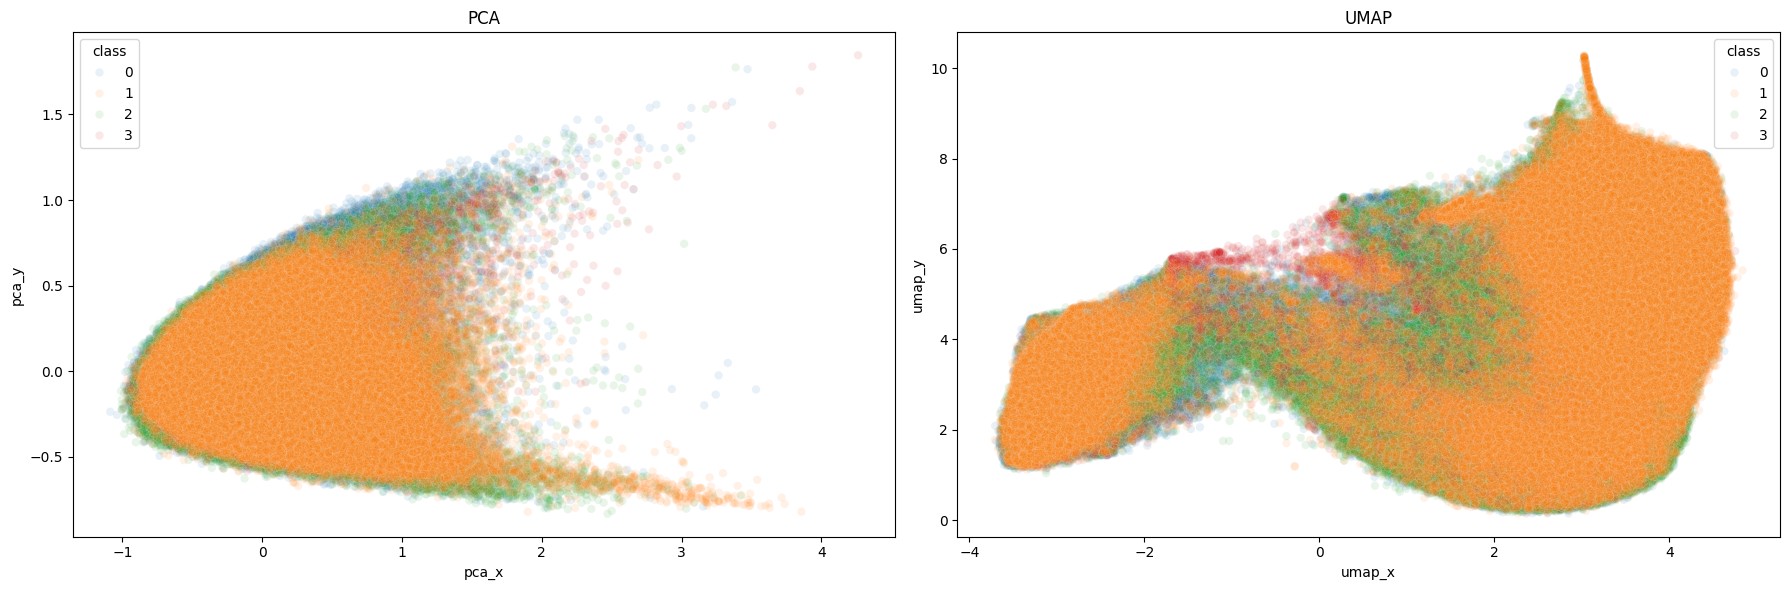

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
df['class'] = classes
# Define figure size and number of subplots
FS = (18, 6)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=FS)

# t-SNE plot


# PCA plot
sns.scatterplot(ax=axes[0], x='pca_x', y='pca_y', hue='class', data=df, palette='tab10', alpha=0.1)
axes[0].set_title('PCA')
axes[0].set_xlabel('pca_x')
axes[0].set_ylabel('pca_y')

# UMAP plot
sns.scatterplot(ax=axes[1], x='umap_x', y='umap_y', hue='class', data=df, palette='tab10', alpha=0.1)
axes[1].set_title('UMAP')
axes[1].set_xlabel('umap_x')
axes[1].set_ylabel('umap_y')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df and cls are already defined
df['class'] = cls
FS = (18, 6)

# Get unique classes
unique_classes = df['class'].unique()

# Loop through each class and create a separate figure
for i, class_label in enumerate(unique_classes):
    # Filter the dataframe for the current class
    df_class = df[df['class'] == class_label]
    
    # Create a figure with 4 subplots
    fig, axes = plt.subplots(1, 4, figsize=FS)

    # t-SNE plot
    sns.scatterplot(ax=axes[0], x='tsne_1', y='tsne_1', hue='class', data=df_class, palette='tab10', alpha=0.7)
    axes[0].set_title(f't-SNE (Class {class_label})')
    axes[0].set_xlabel('tsne_1')
    axes[0].set_ylabel('tsne_1')

    # PCA plot
    sns.scatterplot(ax=axes[1], x='pca_x', y='pca_y', hue='class', data=df_class, palette='tab10', alpha=0.7)
    axes[1].set_title(f'PCA (Class {class_label})')
    axes[1].set_xlabel('pca_x')
    axes[1].set_ylabel('pca_y')

    # UMAP plot
    sns.scatterplot(ax=axes[2], x='umap_x', y='umap_y', hue='class', data=df_class, palette='tab10', alpha=0.7)
    axes[2].set_title(f'UMAP (Class {class_label})')
    axes[2].set_xlabel('umap_x')
    axes[2].set_ylabel('umap_y')

    # You can add a fourth plot here if needed

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()


ValueError: Length of values (4) does not match length of index (309999)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
np.random.seed(0)
features = np.random.rand(100, 128)  # Feature matrix (100 samples, 128 features)
classes = np.random.randint(0, 3, size=100)  # Class labels (3 classes)

# Convert features to DataFrame
features_df = pd.DataFrame(features, columns=[f'feature_{i}' for i in range(features.shape[1])])
features_df['class'] = classes

# Feature-Feature Correlation Matrix
corr_matrix = features_df.drop(columns='class').corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt='.2f')
plt.title('Feature-Feature Correlation Matrix')
plt.show()

# Feature-Class Correlation Matrix
corr_with_classes = features_df.corr()['class'][:-1]  # Exclude the class column itself
corr_with_classes_df = pd.DataFrame(corr_with_classes).reset_index()
corr_with_classes_df.columns = ['Feature', 'Correlation with Class']

plt.figure(figsize=(12, 8))
sns.barplot(x='Feature', y='Correlation with Class', data=corr_with_classes_df)
plt.title('Correlation Between Features and Class Labels')
plt.xticks(rotation=90)
plt.show()


In [ ]:
def perform_statistical_tests(df, component_names):
    results = []

    for comp in component_names:
        # Prepare data for tests
        grouped = [group[comp].values for name, group in df.groupby('class')]

        # ANOVA
        f_stat, p_value_anova = f_oneway(*grouped)

        # Kruskal-Wallis
        h_stat, p_value_kw = kruskal(*grouped)

        # Store results
        results.append({
            'Component': comp,
            'ANOVA F-Statistic': f_stat,
            'ANOVA p-Value': p_value_anova,
            'Kruskal-Wallis H-Statistic': h_stat,
            'Kruskal-Wallis p-Value': p_value_kw
        })

    return pd.DataFrame(results)

# Define the component names to test
component_names = ['pca_1', 'pca_2', 'tsne_1', 'tsne_2', 'umap_1', 'umap_2']

# Perform statistical tests
results_df = perform_statistical_tests(df, component_names)
results_df.sort_values(by='ANOVA p-Value', inplace=True)
print(results_df)


In [ ]:
# Plot ANOVA p-values
plt.figure(figsize=(12, 6))
sns.barplot(x='Component', y='ANOVA p-Value', data=results_df)
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('ANOVA p-Values for PCA, t-SNE, and UMAP Components')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot Kruskal-Wallis p-values
plt.figure(figsize=(12, 6))
sns.barplot(x='Component', y='Kruskal-Wallis p-Value', data=results_df)
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Kruskal-Wallis p-Values for PCA, t-SNE, and UMAP Components')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [2]:
trainset = ImageDataset(data_path='train_data')

In [4]:
trainset.dataset.tail()

,path,class
274385,cells_final/inflammatory/PanNuke_inflamatory_i...,inflammatory
251824,cells_final/inflammatory/aug_16534_MoNuSAC_lym...,inflammatory
254783,cells_final/inflammatory/MoNuSAC_lymphocyte_TC...,inflammatory
224660,cells_final/inflammatory/MoNuSAC_lymphocyte_TC...,inflammatory
145548,cells_final/tumor/aug_12742_PanNuke_neoplastic...,tumor
